# Using deep learning to crack the captcha
In this notebook we will select an image from the pre-processed Captcha images and we'll try to detect what numbers are inside.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf
import cv2
import imutils
import matplotlib.pyplot as plt
from network import ConvNet


Loading the weights of the network we trained and some configurations

In [3]:

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the network
model = ConvNet().to(device)

# Loading the weights
model.load_state_dict(torch.load('model_final.ckpt'))

# Eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=896, out_features=10, bias=True)
)


Choosing a Captcha image to detect:

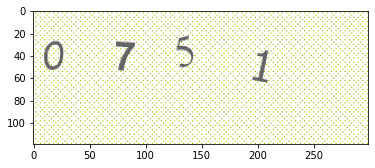

In [4]:
image = cv2.imread("./assets/test.png")
plt.imshow(image)
plt.show()


Decode the image and analyze it:

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Hack for compatibility with different OpenCV versions
contours = contours[1] if imutils.is_cv3() else contours[0]

letter_image_regions = []
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    if w <= 9 or h <= 9:
        continue

    #print(x, y, w, h)
    letter_image_regions.append((x, y, w, h))

# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

predicted_number = ""
output_img = cv2.merge([image])
for letter_bounding_box in letter_image_regions:
    x, y, w, h = letter_bounding_box
    letter_image = gray[y:y + h, x:x + w]

    letter_image = letter_image[0:30,0:18]

    shape_x, shape_y = letter_image.shape

    #new_img = np.resize(letter_image, (28, 28))
    fill_width = np.ones([shape_x, 18 - shape_y]) * 255
    fill_height = np.ones([30 - shape_x, 18]) * 255

    new_img = np.concatenate((letter_image, fill_width), 1)
    new_img = np.concatenate((new_img, fill_height), 0)

    new_img /= 255 # normalize

    with torch.no_grad():
        arg = torch.from_numpy(np.array([[new_img]]))
        output = model(arg.float())

        _, predicted = torch.max(output.data, 1)
        
        letter = str(int(predicted[0]))
        predicted_number += letter
        
        cv2.rectangle(output_img, (x - 4, y - 4), (x + w + 5, y + h + 5), (0, 0, 255), 1)
        cv2.putText(output_img, letter, (x, y - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
predicted_number

'0751'

Showing the digits on the Captcha:

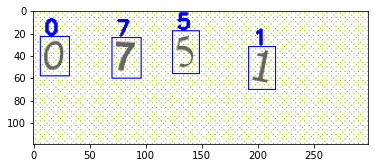

'0751'

In [40]:
plt.imshow(output_img)
plt.show()

predicted_number